# 🔍 MLP for Vulnerability Detection

This script trains a Multi-Layer Perceptron (MLP) model to detect vulnerable source code functions using TF-IDF feature representations extracted from the DiverseVul dataset.

Steps:
1. Load and sample the DiverseVul dataset
2. Convert code text to TF-IDF vectors
3. Train an MLP classifier using TensorFlow/Keras
4. Evaluate the model with metrics and visualizations

In [ ]:
# Force TensorFlow to not use GPU memory (optional safeguard)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [ ]:
# Imports
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

E0000 00:00:1746058035.915086   30604 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746058035.942456   30604 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746058036.123849   30604 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746058036.123917   30604 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746058036.123919   30604 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746058036.123921   30604 computation_placer.cc:177] computation placer already registered. Please check linka

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
import json

# Loading the JSON file
file_path = "...diversevul_20230702.json"       # TODO: Update this path before running

# Load JSONL format line by line
data = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

# Inspect dataset quickly 
df = pd.DataFrame(data)
df.head()

,func,target,cwe,project,commit_id,hash,size,message
0,int _gnutls_ciphertext2compressed(gnutls_sessi...,1,[],gnutls,7ad6162573ba79a4392c63b453ad0220ca6c5ace,73008646937836648589283922871188272089,157,added an extra check while checking the padding.
1,static char *make_filename_safe(const char *fi...,1,[CWE-264],php-src,055ecbc62878e86287d742c7246c21606cee8183,211824207069112513181516095447837228041,22,Improve check for :memory: pseudo-filename in ...
2,"unpack_Z_stream(int fd_in, int fd_out)\n{\n\tI...",1,[],busybox,251fc70e9722f931eec23a34030d05ba5f747b0e,21401706257394042943815500829552774160,232,uncompress: fix buffer underrun by corrupted i...
3,"static void cirrus_do_copy(CirrusVGAState *s, ...",1,[CWE-787],qemu,b2eb849d4b1fdb6f35d5c46958c7f703cf64cfef,135590882627853658533498335902319684573,66,"CVE-2007-1320 - Cirrus LGD-54XX ""bitblt"" heap ..."
4,"glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusV...",1,[CWE-787],qemu,b2eb849d4b1fdb6f35d5c46958c7f703cf64cfef,27696392987383562433164405181263025184,18,"CVE-2007-1320 - Cirrus LGD-54XX ""bitblt"" heap ..."


In [ ]:
# Due to GPU contstraints of my PC, running the model on 100k samples. Feel free to adjust the samples based on GPU power available.
# Sample balanced dataset (85K safe, 15K vulnerable)
 
safe_df = df[df['target'] == 0].sample(85000, random_state=42)
vuln_df = df[df['target'] == 1].sample(15000, random_state=42)
df_100k = pd.concat([safe_df, vuln_df]).sample(frac=1, random_state=42)

texts = df_100k['func'].tolist()
labels = df_100k['target'].tolist()

In [ ]:
import numpy as np

# STEP 1: TF-IDF with 5000 features (safe upper bound)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts[:50000]).toarray()           # Using 50K samples for safety
y = np.array(labels[:50000])

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# STEP 3: Define the MLP model
# Simple feed-forward neural network with dropout for regularization

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')          # Binary classification output
])

In [ ]:
# STEP 4: Compile model with Adam optimizer and binary crossentropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
# STEP 5: Train (with smaller batch size to avoid OOM)
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8470 - loss: 0.4403 - val_accuracy: 0.8545 - val_loss: 0.3769
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8509 - loss: 0.3451 - val_accuracy: 0.8577 - val_loss: 0.3766
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8760 - loss: 0.2980 - val_accuracy: 0.8530 - val_loss: 0.3980
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9052 - loss: 0.2452 - val_accuracy: 0.8365 - val_loss: 0.4355
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9333 - loss: 0.1786 - val_accuracy: 0.8425 - val_loss: 0.4738
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9494 - loss: 0.1318 - val_accuracy: 0.8260 - val_loss: 0.5577
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9607 - loss: 0.1020 - val_accuracy: 0.8338 - val_loss: 0.6078
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9679 - loss: 0.0819 - val_accu

In [11]:
# Predict & Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      8503
           1       0.40      0.32      0.35      1497

    accuracy                           0.83     10000
   macro avg       0.64      0.62      0.63     10000
weighted avg       0.81      0.83      0.82     10000



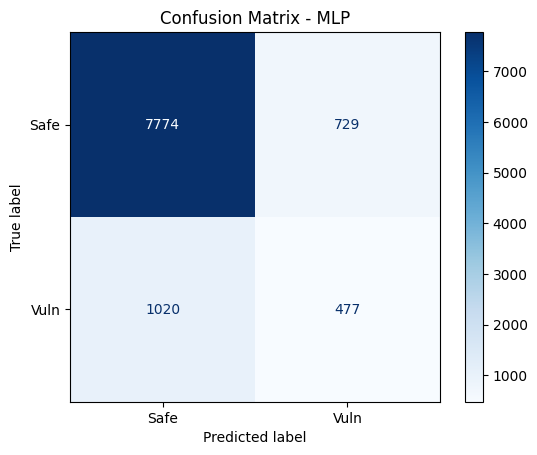

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Vuln"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - MLP")
plt.show()

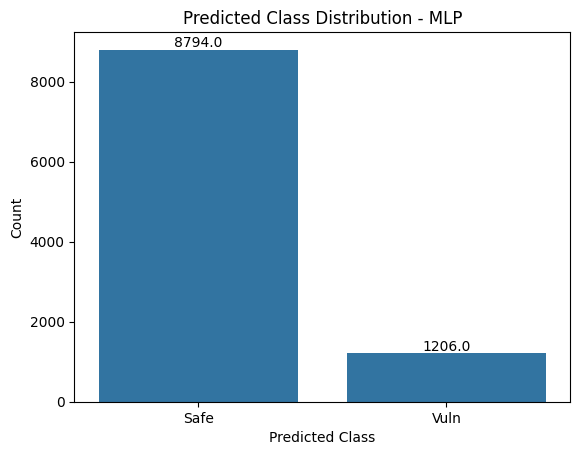

In [ ]:
# Plotting graphs for MLP
import seaborn as sns

# Count plot for predicted labels
ax = sns.countplot(x=y_pred.flatten())
plt.title("Predicted Class Distribution - MLP")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks([0, 1], ["Safe", "Vuln"])

# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.show()

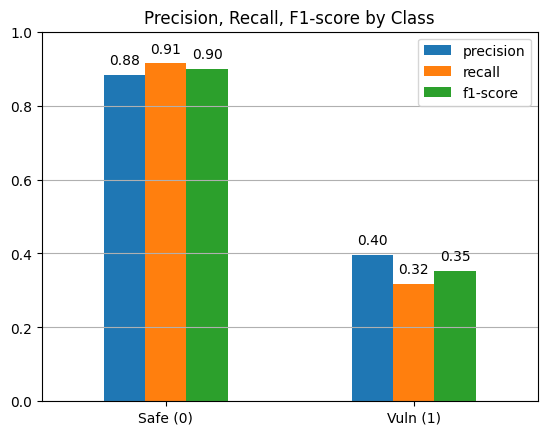

: 

In [ ]:
# Plotting graphs for MLP
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Generate report and extract class 0 and 1
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
metrics = df_report.loc[["0", "1"], ["precision", "recall", "f1-score"]]

# Plot
ax = metrics.plot(kind='bar')
plt.title("Precision, Recall, F1-score by Class")
plt.xticks([0, 1], ["Safe (0)", "Vuln (1)"], rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')

# Add values on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.02),
                ha='center', va='bottom')

plt.show()
